In [50]:
import pandas as pd
import numpy as np
#import random
#from tqdm import tqdm
#from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import cm
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore')

In [ ]:
dataset=pd.read_excel('C:/Personal/NUIG/Project-DA/online_retail_II.xlsx',sheet_name=None)
Data_Cleaned = dataset['Year 2009-2010'].append(dataset['Year 2010-2011'],ignore_index=True)
Data_Cleaned.head()

#remove all customers with NA customer ID
Data_Cleaned = Data_Cleaned[Data_Cleaned['Customer ID'].notna()]

#remove the negative quantity values and duplicate transactions
data = Data_Cleaned[(Data_Cleaned['Price'] > 0) & (Data_Cleaned['Quantity']>0)]
data.drop_duplicates(inplace = True)

data['Final_Price'] = data['Price'] * data['Quantity']

In [32]:
data_1 = data[['Customer ID','Description','Final_Price']]
data_1['Description'] = data_1['Description'].str.lower()
stop_words =['flower','rose','candle','heart','small', 'large','light','lights','black', 'red', 'blue', 'green', 'white',  'pink','glass', 'silver','set','vintage','design','hanging',
                  'of','in','s','f','t']
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
data_1['Description'] = data_1['Description'].str.replace(pat, '')
    

In [33]:
#grouping on the basis of price for each category to get the data at customer level
cust_level=data.pivot_table(index=["Customer ID"], columns='Description', values = 'Final_Price',
                        aggfunc='sum').reset_index()

cust_level=cust_level.fillna(0)
cust_level.drop(['Customer ID'],axis = 'columns',inplace=True)

In [36]:
pca = PCA(n_components = 6)
prin_comp = pca.fit_transform(customer_spending_per_category)
variance = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, variance.shape[0] + 1),
    y=variance,
    labels={"x": "Components", "y": "Variance"})

In [37]:
comp = pd.DataFrame(prin_comp)

cust_id_only = data[['Customer ID','Final_Price']]
cust_id_only=cust_id_only.pivot_table(index=["Customer ID"], 
                   values = 'Final_Price',
                        aggfunc='sum').reset_index()

data_2 = pd.concat([cust_id_only, comp], axis='columns')

In [38]:
#save the dataset
#data_2.to_pickle('PCA_RED_DESC_v2.pkl') 

## Model 2

In [39]:
#read prod category and rfm data
prod_cat = pd.read_pickle('PCA_RED_DESC_v2.pkl')
rfm = pd.read_pickle('rfm.pkl')

In [40]:
final_data = pd.merge(prod_cat,rfm,on='Customer ID')
final_data_new = pd.merge(prod_cat,rfm,on='Customer ID')

final_data.rename(columns={0:'0',1:'1',2:'2',3:'3',4:'4',5:'5'})
final_data.drop(['RFM_Segment','Customer ID','R','F','M','Final_Price','RFM_Score','Monetary_value'],axis = 'columns',inplace=True)

In [42]:
#Rescaling
from sklearn.preprocessing import MinMaxScaler
numeric_columns = final_data.columns.values.tolist()
scaler = MinMaxScaler() 
final_data[numeric_columns] = scaler.fit_transform(final_data[numeric_columns])

#
# scores_2 = []

# range_values = range(1, 20)

# for i in range_values:
    
#     kmeans = KMeans(n_clusters= i)
#     kmeans.fit(final_data)
#     scores_2.append(kmeans.inertia_)
# plt.figure(figsize=(10,10))
# plt.plot(scores_2, 'bx-')
# plt.xlabel('Clusters')
# plt.ylabel('scores') 
# plt.show()


kmeans = KMeans(3)
kmeans.fit(final_data)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(final_data)

output_clus = pd.concat([final_data_new, pd.DataFrame({'cluster_final':labels})], axis = 1)
print(output_clus['cluster_final'].value_counts())
silhouette_avg = silhouette_score(final_data, y_kmeans)
print('score de silhouette: {}'.format(silhouette_avg))

0    3601
2    1499
1     778
Name: cluster_final, dtype: int64


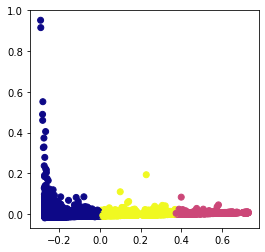

In [43]:
pca = PCA(n_components = 2)
prin_comp = pca.fit_transform(final_data)
plt.scatter(prin_comp[:,0],prin_comp[:,1],c=labels,cmap="plasma")
ax = plt.gca()
ax.set_aspect(1) 

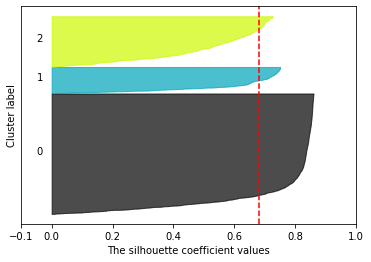

In [47]:
#reference: https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
sample_silhouette_values = silhouette_samples(final_data, y_kmeans)
fig, (ax1) = plt.subplots(1, 1)
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_kmeans == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_aspect(1) 
plt.show()

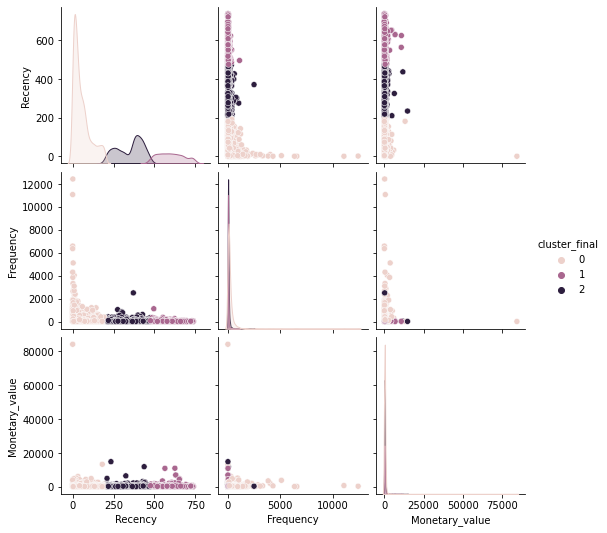

In [51]:
output_cluster_1 = output_clus[['Recency','Frequency','Monetary_value','cluster_final']]
sns.pairplot(output_cluster_1, hue = 'cluster_final')

In [53]:
# save the model to disk
import pickle
filename = 'Method2_Model.sav'
pickle.dump(kmeans, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
#df_cluster_dr.to_csv('3_clusters_M2_wo_monetary.csv')

## References:

#### 1. https://stackoverflow.com/questions/55533962/removing-specific-word-in-a-string-in-pandas